In [1]:
%%capture
pip install pennylane

In [2]:
import pennylane as qml
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
import matplotlib.pyplot as plt

## Electron-Photon dataset

In [3]:
import h5py
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torchvision import transforms

path_ep = "/home/lazaror/quantum/pruebas/EQCNN_local_testing/EQNN_for_HEP/Equivariant_QCNN/data/E-P_rescaled"
with h5py.File(path_ep, "r") as file:
    X_ep = np.array(file["X"])
    y_ep = np.array(file["y"])

X_train_16, X_test_16, Y_train_16, Y_test_16 = train_test_split(X_ep, y_ep, test_size=0.2, random_state=42, stratify=y_ep)

transform = transforms.Compose([
    transforms.ToPILImage(),          
    transforms.Resize((16, 16)),     
    transforms.ToTensor()            
])

X_train_resized = torch.stack([transform(x) for x in X_train_16])
X_test_resized = torch.stack([transform(x) for x in X_test_16])

X_train = X_train_resized.permute(0, 2, 3, 1)  
X_test = X_test_resized.permute(0, 2, 3, 1)   

y_train = torch.tensor(Y_train_16)
y_test = torch.tensor(Y_test_16)

print(X_train.shape)  
print(X_test.shape)

torch.Size([160000, 16, 16, 1])
torch.Size([40000, 16, 16, 1])


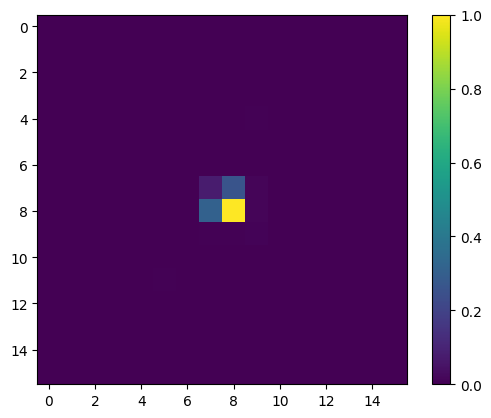

tensor(1, dtype=torch.int32)


In [4]:
n = 5
plt.imshow(X_train[n])
plt.colorbar()
plt.show()
print(y_train[n])

## model: FC + QC + FC + SOFTMAX


In [5]:
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

In [6]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes) 

clayer_1 = torch.nn.Linear(256, 256) 
clayer_2 = torch.nn.Linear(8, 2) 
softmax = torch.nn.Softmax(dim=1) 

layers = [clayer_1, qlayer, clayer_2, softmax]
model = torch.nn.Sequential(*layers)

opt = torch.optim.SGD(model.parameters(), lr=0.1)
loss = torch.nn.L1Loss()

In [7]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

print(model[1].parameters())  

Total trainable parameters: 65858
<generator object Module.parameters at 0x7f40a97cf0d0>


In [8]:
import torch
import torch.nn.functional as F

num_classes = 2
samples = 20000
y_train_one_hot = F.one_hot(y_train[:samples].to(torch.int64), num_classes=num_classes) 

X = X_train[:samples].reshape(samples, 16*16).float().requires_grad_(True)
y_hot = y_train_one_hot.long()


batch_size = 128
batches = samples // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=batch_size, shuffle=True, drop_last=True
)

epochs = 25

for epoch in range(epochs):
    running_loss = 0
    for xs, ys in data_loader:
        opt.zero_grad()
        y_pred = model(xs)
        loss_evaluated = loss(y_pred, ys)
        loss_evaluated.backward()
        opt.step()
        running_loss += loss_evaluated.item()
    avg_loss = running_loss / batches 
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))


Average loss over epoch 1: 0.4998
Average loss over epoch 2: 0.4957
Average loss over epoch 3: 0.4767
Average loss over epoch 4: 0.4469
Average loss over epoch 5: 0.4320
Average loss over epoch 6: 0.4258
Average loss over epoch 7: 0.4207
Average loss over epoch 8: 0.4117
Average loss over epoch 9: 0.4141
Average loss over epoch 10: 0.4068
Average loss over epoch 11: 0.4103
Average loss over epoch 12: 0.4044
Average loss over epoch 13: 0.4001
Average loss over epoch 14: 0.3993
Average loss over epoch 15: 0.4122
Average loss over epoch 16: 0.3965
Average loss over epoch 17: 0.3968
Average loss over epoch 18: 0.3985
Average loss over epoch 19: 0.4015
Average loss over epoch 20: 0.3956
Average loss over epoch 21: 0.3949
Average loss over epoch 22: 0.3925
Average loss over epoch 23: 0.3931
Average loss over epoch 24: 0.3907
Average loss over epoch 25: 0.3930


In [14]:
samples = 5000
X = X_train[:samples].reshape(samples, 16*16).float().requires_grad_(True)

y_pred = model(X)

_, y_pred_classes = torch.max(y_pred, dim=1)
y_pred_classes = y_pred_classes.detach().numpy()

correct = (y_pred_classes == y_train[:samples].numpy()).sum()
accuracy = correct / len(y_train[:samples])
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 61.199999999999996%


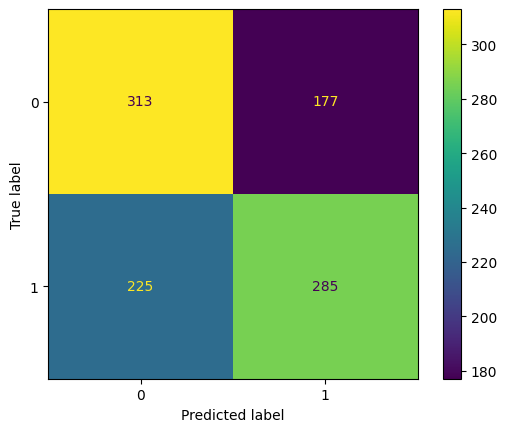

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_samples = 1000
X_test = X_test[:test_samples].reshape(test_samples, 16*16).float().requires_grad_(True)

y_pred = model(X_test)
_, y_pred_classes = torch.max(y_pred, dim=1)
y_pred_classes = y_pred_classes.detach().numpy()

cm = confusion_matrix(y_test[:test_samples], y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()